In [82]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import sklearn.neighbors as knn

In [3]:
# repeatable seed
random_state = 2**12
np.random.seed(seed=random_state)

In [4]:
# an AND gate has 4 possible outcomes: 0^0=0, 0^1=0, 1^0=0, 1^1=1
# Since the state can only be 0 or 1, I propolate the sample with Logistic Distribution
n = 1000
mean, scale = 0.5, 0.15
x1 = np.random.logistic(mean, scale, n)
x2 = np.random.logistic(mean, scale, n)
x = np.column_stack((x1, x2))

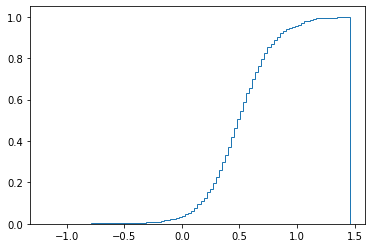

In [5]:
bins=100
plt.figure()
plt.hist(x1, bins, density=True, histtype='step', cumulative=True, label='CDF')
plt.show()

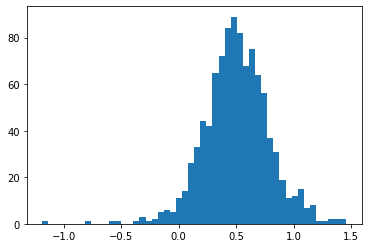

In [6]:
plt.figure()
count, bins, ignored = plt.hist(x1, bins=50)
plt.show()

In [7]:
y = np.array([1 if x_i[0] >= 0.5 and x_i[1] >= 0.5 else 0 for x_i in x])

In [8]:
# around 25% of points are output 1
print(y[y==1].size/n)

0.257


In [9]:
figsize = np.array(plt.rcParams["figure.figsize"]) * 2

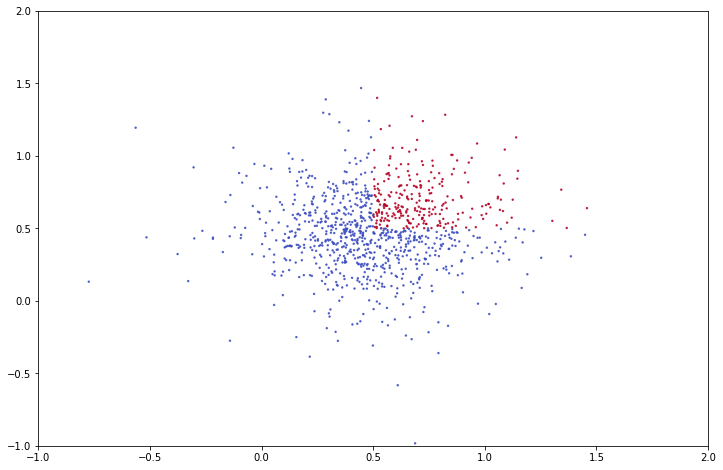

In [10]:
x_min, x_max = -1.0, 2

plt.figure(figsize=figsize.tolist())
plt.scatter(x[:, 0], x[:, 1], marker='.', c=y, alpha=0.8, cmap=plt.cm.coolwarm, s=8, edgecolor='face')
plt.grid(False)
plt.xlim(x_min, x_max)
plt.ylim(x_min, x_max)
plt.show()

In [11]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20)

In [12]:
# SVM
gamma = 10.0
C = 1000
model_svm1 = svm.SVC(kernel='rbf', decision_function_shape='ovo', random_state=random_state, gamma=gamma, C=C)
model_svm1.fit(x_train, y_train)

SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovo', degree=3, gamma=10.0, kernel='rbf',
    max_iter=-1, probability=False, random_state=4096, shrinking=True,
    tol=0.001, verbose=False)

In [13]:
print(f'With gamma={gamma} and C={C}')

y_pred = model_svm1.predict(x_train)
score = accuracy_score(y_train, y_pred)
print(f'Accuracy on train set = {score*100:.3f}%')

y_pred = model_svm1.predict(x_test)
score = accuracy_score(y_test, y_pred)
print(f'Accuracy on test set = {score*100:.3f}%')

With gamma=10.0 and C=1000
Accuracy on train set = 99.250%
Accuracy on test set = 97.500%


In [14]:
print(model_svm1.predict([[1., 1.]]))
print(model_svm1.predict([[1., 0.]]))
print(model_svm1.predict([[0., 1.]]))
print(model_svm1.predict([[0., 0.]]))

[1]
[0]
[0]
[0]


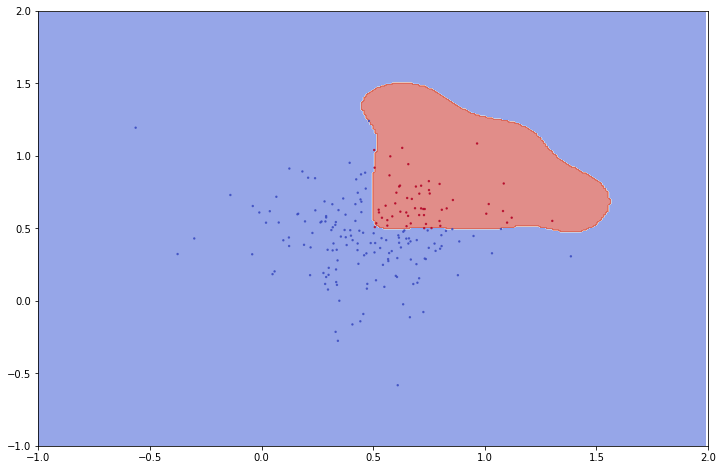

In [15]:
h = .01
# by symmetry x and y axis should be in same range
# x_min, x_max = x_test[:, 0].min() - 1, x_test[:, 0].max() + 1
x_min, x_max = -1.0, 2

xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(x_min, x_max, h))
Z = model_svm1.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=figsize.tolist())
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.6)
plt.scatter(x_test[:, 0], x_test[:, 1], c=y_test, marker='.', alpha=0.8, cmap=plt.cm.coolwarm, s=8, edgecolor='face')
plt.xlim(x_min, x_max)
plt.ylim(x_min, x_max)
plt.show()

In [77]:
def print_adversarial_examples(model):
    print(f'0.530 ^ 1.420 = {model_svm1.predict([[.53, 1.42]])[0]}')
    print(f'0.540 ^ 1.420 = {model_svm1.predict([[.54, 1.42]])[0]}')
    print(f'0.540 ^ 1.430 = {model_svm1.predict([[.54, 1.43]])[0]}\n')

    print(f'0.530 ^ 1.430 = {model_svm1.predict([[.53, 1.43]])[0]}')
    print(f'0.520 ^ 1.430 = {model_svm1.predict([[.52, 1.43]])[0]}\n')

    print(f'0.500 ^ 0.499 = {model_svm1.predict([[.5, .499]])[0]}')
    print(f'0.501 ^ 0.510 = {model_svm1.predict([[.501, .51]])[0]}')

In [78]:
print_adversarial_examples(model_svm1)

0.530 ^ 1.420 = 1
0.540 ^ 1.420 = 1
0.540 ^ 1.430 = 1

0.530 ^ 1.430 = 1
0.520 ^ 1.430 = 1

0.500 ^ 0.499 = 0
0.501 ^ 0.510 = 0


In [18]:
model_svm1.get_params()

{'C': 1000,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovo',
 'degree': 3,
 'gamma': 10.0,
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 4096,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

### SVM with overfit parameter

By increasing gamma, kernel function works better in the center.

In [19]:
gamma = 60.0
C = 1000
model_svm2 = svm.SVC(kernel='rbf', decision_function_shape='ovo', random_state=random_state, gamma=gamma, C=C)
model_svm2.fit(x_train, y_train)

SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovo', degree=3, gamma=60.0, kernel='rbf',
    max_iter=-1, probability=False, random_state=4096, shrinking=True,
    tol=0.001, verbose=False)

In [20]:
print(f'With gamma = {gamma} and C = {C}')
y_pred = model_svm2.predict(x_train)
score = accuracy_score(y_train, y_pred)
print(f'Accuracy on train set = {score*100:.3f}%')

y_pred = model_svm2.predict(x_test)
score = accuracy_score(y_test, y_pred)
print(f'Accuracy on test set = {score*100:.3f}%')

With gamma=60.0 and C=1000
Accuracy on train set = 100.000%
Accuracy on test set = 96.500%


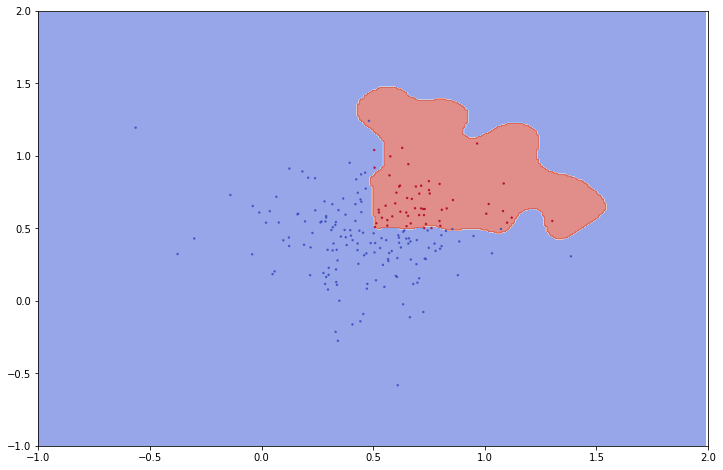

In [21]:
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(x_min, x_max, h))
Z = model_svm2.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=figsize.tolist())
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.6)
plt.scatter(x_test[:, 0], x_test[:, 1], c=y_test, marker='.', alpha=0.8, cmap=plt.cm.coolwarm, s=8, edgecolor='face')
plt.xlim(x_min, x_max)
plt.ylim(x_min, x_max)
plt.show()

In [22]:
print_adversarial_examples(model_svm2)

0.53^1.42=1
0.54^1.42=1
0.54^1.43=1

0.53^1.43=1
0.52^1.43=1

0.5^0.499=0
0.501^0.51=0


In [23]:
model_svm2.get_params()

{'C': 1000,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovo',
 'degree': 3,
 'gamma': 60.0,
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 4096,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

## Conclusion

The adversarial examples do exist in both models, but in different regions.

## Neural Network Model

In [24]:
import tensorflow as tf
from tensorflow import keras

In [25]:
model_nn = keras.Sequential([
    keras.layers.Dense(2, 
                       input_shape=(2,), 
                       activation='relu', 
                       kernel_initializer=tf.initializers.GlorotNormal
                      ),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

In [26]:
model_nn.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), 
                 loss='binary_crossentropy', 
                 metrics=['accuracy'])

In [27]:
model_nn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2)                 6         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3         
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


In [28]:
epochs = 20
batch_size = 32
model_nn.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
model_nn.evaluate(x_test, y_test, verbose=2)

200/1 - 0s - loss: 0.3709 - accuracy: 0.8450


[0.32880852460861204, 0.845]

In [29]:
model_nn.weights

[<tf.Variable 'dense/kernel:0' shape=(2, 2) dtype=float32, numpy=
 array([[1.3773106, 0.9738443],
        [1.5055795, 1.0402918]], dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(2,) dtype=float32, numpy=array([-1.2668059, -0.8894321], dtype=float32)>,
 <tf.Variable 'dense_1/kernel:0' shape=(2, 1) dtype=float32, numpy=
 array([[1.9472187],
        [2.5622396]], dtype=float32)>,
 <tf.Variable 'dense_1/bias:0' shape=(1,) dtype=float32, numpy=array([-2.4059098], dtype=float32)>]

In [76]:
print(f'1 ^ 1 = {model_nn.predict([[1.0, 1.0]])[0][0]:.4f}')
print(f'0 ^ 1 = {model_nn.predict([[.0, 1.0]])[0][0]:.4f}')
print(f'1 ^ 0 = {model_nn.predict([[1.0, .0]])[0][0]:.4f}')
print(f'1 ^ 0 = {model_nn.predict([[.0, .0]])[0][0]:.4f}')

1 ^ 1 = 0.9740
0 ^ 1 = 0.1744
1 ^ 0 = 0.1219
1 ^ 0 = 0.0827


In [71]:
print(f'0.530 ^ 1.420 = {model_nn.predict([[.53, 1.42]])[0][0]:.4f}')
print(f'0.540 ^ 1.420 = {model_nn.predict([[.54, 1.42]])[0][0]:.4f}')
print(f'0.540 ^ 1.430 = {model_nn.predict([[.54, 1.43]])[0][0]:.4f}\n')

print(f'0.530 ^ 1.430 = {model_nn.predict([[.53, 1.43]])[0][0]:.4f}')
print(f'0.520 ^ 1.430 = {model_nn.predict([[.52, 1.43]])[0][0]:.4f}\n')

print(f'0.500 ^ 0.499 = {model_nn.predict([[.5, .499]])[0][0]:.4f}')
print(f'0.501 ^ 0.510 = {model_nn.predict([[.501, .51]])[0][0]:.4f}')

0.530 ^ 1.420 = 0.9718
0.540 ^ 1.420 = 0.9732
0.540 ^ 1.430 = 0.9746

0.530 ^ 1.430 = 0.9733
0.520 ^ 1.430 = 0.9719

0.500 ^ 0.499 = 0.1455
0.501 ^ 0.510 = 0.1540


## Applicability Domain

In [69]:
# Testing block
# all positive samples
x_pos = x_train[np.where(y_train == 1)]
x_pos_max = np.amax(x_pos, axis=0)
x_pos_min = np.amin(x_pos, axis=0)
print('Positive range:')
print(f'{x_pos_min[0]:.5f} <= x1 <= {x_pos_max[0]:.5f}')
print(f'{x_pos_min[1]:.5f} <= x2 <= {x_pos_max[1]:.5f}')

# all negative samples
x_neg = x_train[np.where(y_train == 0)]
x_neg_max = np.amax(x_neg, axis=0)
x_neg_min = np.amin(x_neg, axis=0)
print('\nNegative range:')
print(f'{x_neg_min[0]:.5f} <= x1 <= {x_neg_max[0]:.5f}')
print(f'{x_neg_min[1]:.5f} <= x2 <= {x_neg_max[1]:.5f}')

Positive range:
0.50129 <= x1 <= 1.45742
0.50057 <= x2 <= 1.40002

Negative range:
-0.77458 <= x1 <= 1.44902
-0.98286 <= x2 <= 1.46801


In [65]:
# Hand picked set which contains Adversarial Examples
test_x = np.array([
    # standard
    [1.000, 1.000],  # 1
    [1.000, 0.000],  # 0
    [0.000, 1.000],  # 0
    [0.000, 0.000],  # 0
    # top centre
    [0.530, 1.430],  # 1
    [0.520, 1.430],  # 1
    [0.490, 1.430],  # 0
    [0.490, 1.450],  # 0
    # centre
    [0.502, 0.499],  # 0
    [0.502, 0.501],  # 1
    [0.502, 0.510],  # 1
    [0.499, 0.499],  # 0
    # out of training range
    # positive
    [0.5001, 1.200], # 1
    [1.200, 0.5001], # 1
    [0.510, 1.420],  # 1
    [1.470, 0.510],  # 1
    # negative
    [-0.780, 0.999], # 0
    [0.999, -0.990], # 0
    [1.460, 0.000],  # 0
    [0.000, 1.480]   # 0
])

test_y = np.array([1,0,0,0, 1,1,0,0, 0,1,1,0, 1,1,1,1, 0,0,0,0])
print(f'Check length: {len(test_x) == len(test_y)}')

Check length: True


In [64]:
pred = model_svm1.predict(test_x)

# get indices for misclassified samples
idx_mis = np.where(np.logical_xor(test_y, pred) == True)

print('Misclassified samples:')
print(*test_x[idx_mis], sep='\n')
print('\nTrue class:')
print(*test_y[idx_mis], sep=', ')
print('\nPredictions:')
print(*pred[idx_mis], sep=', ')

Misclassified samples:
[0.49 1.43]
[0.502 0.501]
[0.502 0.51 ]
[1.2    0.5001]

True class:
0, 1, 1, 1

Predictions:
1, 0, 0, 0


In [58]:
def check_applicability(inputs, x_train, y_train, classes=[0,1]):
    """Check the bounding box of the inputs. This tests the max and min
    value for every class. Each input sample must in range of one of the classes
    in training set.
    
    Parameters
    ----------
    inputs: array-like matrix of shape (n_samples, n_features)
    
    x_train: array-like matrix with same number of features as inputs
    
    y_train: array
        Training labels
    
    classes: array
        Categorical outputs of y_train
    
    Returns
    -------
    outputs: array-like matrix
        All inputs which passed the filter
    
    indices: array
        The original indices of outputs in inputs
    """
    # the input only need to within one of the classes
    idx_set = set()
    
    # looping through classes
    for c in classes:
        x = x_train[np.where(y_train == c)]
        x_max = np.amax(x, axis=0)
        x_min = np.amin(x, axis=0)
        idx = np.where(np.all(np.logical_and(inputs <= x_max, inputs >= x_min), axis=1))[0]
        idx_set.update(idx)
    
    input_indices = np.array(list(idx_set))
    outputs = inputs[input_indices]
    
    
    return outputs, input_indices

In [59]:
def get_filtered_indices(passed_ind, inputs):
    """Get the indices where are not in the passed_ind.

    Parameters
    ----------
    passed_ind: array
        indices of the inputs
    
    inputs: array-like matrix


    Returns
    -------
    exclude_ind: array
        indices where are not include in passed_ind
    """
    if np.max(passed_ind) >= len(inputs):
        return np.array([])
    return np.where(np.isin(np.array(range(len(inputs))), idx_within) == False)[0]

In [80]:
# Testing block
x_passed, idx_within = check_applicability(test_x, x_train, y_train)
# print('Passed samples:')
# print(*x_passed, sep='\n')
# print()
print(f'Pass rate = {len(x_passed) / len(test_x) * 100.0}%')

Pass rate = 75.0%


In [62]:
blocked_ind = get_filtered_indices(idx_within, test_x)
print('Blocked by Bounding box (Applicability Domain):')
print(*test_x[blocked_ind], sep='\n')

Blocked by Bounding box (Applicability Domain):
[1.47 0.51]
[-0.78   0.999]
[ 0.999 -0.99 ]
[1.46 0.  ]
[0.   1.48]


In [84]:
train_pos_ind = np.where(y_train==1)
train_neg_ind = np.where(y_train==0)
x_train_pos = x_train[train_pos_ind]
x_train_neg = x_train[train_neg_ind]

In [85]:
# # of neighbours in kNN model
k = 9

In [94]:
# Build one model for each class. 
# The prediction of these models should NOT be used. (All samples have same label.)
model_knn_pos = knn.KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
model_knn_pos.fit(x_train_pos, np.ones(len(x_train_pos)))

model_knn_neg = knn.KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
model_knn_neg.fit(x_train_neg, np.zeros(len(x_train_neg)))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=9, p=2,
                     weights='uniform')

In [95]:
def get_dist_info(model, x_train, k):
    """ Computing mean and standard deviation of distance in kNN model

    Returns
    -------
    mu: float
        mean distance

    sd: float
        standard deviation
    """
    # k+1: The neighbours will include themselves
    train_dist, _ = model.kneighbors(x_train, n_neighbors=k+1)
    avg_dist = np.sum(train_dist, axis=1) / (k + .0)
    mu = np.mean(avg_dist)
    sd = np.std(avg_dist)
    return mu, sd

In [98]:
mu_pos_dist, sd_pos_dist = get_dist_info(model_knn_pos, x_train_pos, k)
print('Distance of positive samples in traing set:')
print('{:18s} = {:.5f}'.format('Mean', mu_pos_dist))
print('{:18s} = {:.5f}\n'.format('Standard deviation', sd_pos_dist))

mu_neg_dist, sd_neg_dist = get_dist_info(model_knn_neg, x_train_neg, k)
print('Distance of negative samples in traing set:')
print('{:18s} = {:.5f}'.format('Mean', mu_neg_dist))
print('{:18s} = {:.5f}\n'.format('Standard deviation', sd_neg_dist))

Distance of positive samples in traing set:
Mean               = 0.05914
Standard deviation = 0.05079

Distance of negative samples in traing set:
Mean               = 0.05698
Standard deviation = 0.06082



In [100]:
# parameter for proportion
# 95%
zeta = 1.959
pos_dist_threshold = mu_pos_dist + zeta * sd_pos_dist
neg_dist_threshold = mu_pos_dist + zeta * sd_neg_dist
print(f'Positive distance threshold = {pos_dist_threshold:.5f}')
print(f'Negative distance threshold = {neg_dist_threshold:.5f}')

Positive distance threshold = 0.15864
Negative distance threshold = 0.17829


In [37]:
def check_reliability(inputs, predictions, x_train, y_train, dist_threshold, k=9):
    """Computing the distance for k in-class neighbours,
    and filtering out all inputs above the threshold.
    
    Parameters
    ----------
    inputs: array-like matrix of shape (n_samples, n_features)
    
    predictions: array
        The predictions of Labels for inputs. This function does not 
        directly access the model.
    
    x_train: array-like matrix with same number of features as inputs
    
    y_train: array
        Training labels
    
    distance_threshold: float
        The cut-off distance
    
    k: int
        The # of nearlest neighbours
    
    Returns
    -------
    outputs: array-like matrix
        All inputs which passed the filter
    
    indices: array
        The original indices of outputs in inputs
    """
    